In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset, singleCET_ProjectedDataset

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from torch.utils.data import Dataset, DataLoader

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Make grid method

I want to create a set of overlapping intervals of size subtomo_length that cover the entire tomogram and that dont overlap too much to reduce the number of intervals that I need to cover the tomogram.

## Pilot in 1D

In [16]:
L = 928
s = 64

n_intervals = L/s
n_intervals # the decimal part means we have a surplus

14.5

In [29]:
surplus = L%s
surplus

32

So what should happen now is that this surplus should be distributed across L such that it is completely covered with little overlap.

To achieve this, I can create one more interval across L, however I still need to fulfill some constraints:
1. All of the intervals should have the same size s. 
2. The amount of overlapping might vary, but it needs to be small

In [30]:
pcenters, step = np.linspace(s//2, L-s//2, int(np.ceil(n_intervals)), dtype=int, retstep=True)
intervals, step

(array([ 4, 11, 19, 27, 34, 42, 50, 57, 65, 73, 80, 88, 96]),
 61.714285714285715)

In [31]:
startpoints, endpoints = pcenters-s//2, pcenters+s//2
max(endpoints[:-1]-startpoints[1::])/s # overlap

0.046875

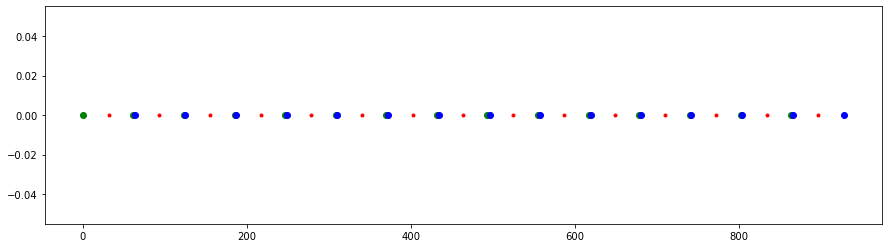

In [32]:
y0 = np.zeros_like(pcenters)

plt.figure(figsize=(15, 4))
plt.scatter(x=pcenters, y=y0, c='r', marker='.')
plt.scatter(x=startpoints, y=y0, c='g')
plt.scatter(x=endpoints, y=y0, c='b')

## 3D tomogram

In [18]:
cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
tomo_data = read_array(cet_path)

subtomo_length = 128

tomo_data.shape

(464, 928, 928)

In [19]:
zyx = tomo_data.shape # tomogram dimensions
max_length = max(zyx)
dist_center = subtomo_length//2 # size from center

n_centers = int(np.ceil(max_length/subtomo_length))
n_centers

8

In [23]:
pcenters = []
for i, coord in enumerate(zyx):

    n_centers = int(np.ceil(coord/subtomo_length))
    pcenter = np.linspace(dist_center, coord-dist_center, n_centers, dtype=int)
    
    startpoints, endpoints = pcenter-dist_center, pcenter+dist_center
    overlap_ratio = max(endpoints[:-1]-startpoints[1::])/dist_center # overlap

    pcenters.append(pcenter)
    print(overlap_ratio)
    
    if overlap_ratio<0:
        raise ValueError('The tomogram is not fully covered in dimension %i.' %i)
        
    if overlap_ratio>0.5:
        raise ValueError('There is too much overlap between patches in dimension %i.' %i)

z, y, x = zyx

0.25
0.21875
0.21875


In [22]:
overlap_ratio

0.21875

In [13]:
zs, ys, xs = np.meshgrid(*pcenters, indexing='ij')
grid = list(zip(zs.flatten(), ys.flatten(), xs.flatten()))
len(grid)

1800

# Bernoulli Dataset

In [15]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')
gt_cet_path = None
# simulated_model = 'model14'
# cet_path = os.path.join(
#     PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s_Poisson5000+Gauss5+stripes.mrc" %simulated_model
# )
# gt_cet_path = os.path.join(
#     PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s.mrc" %simulated_model
# )


p=0.3
batch_size = 8
num_gpus = 2
subtomo_length = 96

deconv_kwargs = {'angpix': 14,
                 'defocus': 0,
                 'snrfalloff': 1,
                 'deconvstrength': 1,
                 'highpassnyquist': 0.3}

my_dataset = singleCET_dataset(cet_path, subtomo_length, p=p, volumetric_scale_factor=8, gt_tomo_path=gt_cet_path, n_shift=0, **deconv_kwargs)
print('Size of dataset: %i, Steps per epoch: %i' %(len(my_dataset), len(my_dataset)/(batch_size*num_gpus)))

Using deconvolved data for training.
Size of dataset: 75, Steps per epoch: 4


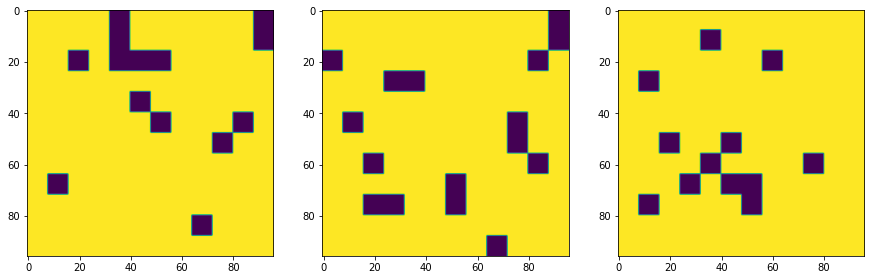

In [16]:
mask = my_dataset.create_Vmask()[0]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))

aux_idx = subtomo_length//2
ax0.imshow(mask[aux_idx])
ax1.imshow(mask[:,aux_idx, :])
ax2.imshow(mask[:, :,aux_idx])

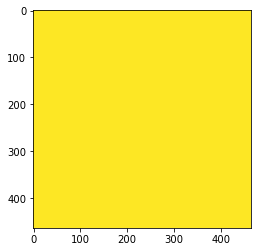

In [17]:
# grid sanity check: grid cover the entire tomogram
tomo_data = my_dataset.data

dummy_tomo = torch.zeros_like(torch.tensor(tomo_data))

for idx in range(len(my_dataset)):
    
    z0, y0, x0 = my_dataset.grid[idx]
    zmin, zmax = z0-subtomo_length//2, z0+subtomo_length//2
    ymin, ymax = y0-subtomo_length//2, y0+subtomo_length//2
    xmin, xmax = x0-subtomo_length//2, x0+subtomo_length//2

    dummy_tomo[zmin:zmax, ymin:ymax, xmin:xmax] = 1
    
plt.imshow(dummy_tomo[-1], vmin=0, vmax=1)

In [18]:
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 8))
# zidx = my_dataset.tomo_shape[0]//2
# ax0.imshow(my_dataset.data[zidx])
# ax1.imshow(my_dataset.bernoulli_mask[0][zidx])

In [19]:
# check last set of dimensions across Z
tomo_data.shape, dummy_tomo[zmin:zmax].shape, zmin, zmax

(torch.Size([232, 464, 464]), torch.Size([96, 464, 464]), 136, 232)

In [20]:
ymax, xmax

(464, 464)

In [21]:
idx = 10
subtomo, target, mask, gt_subtomo = my_dataset[idx]
subtomo.shape

torch.Size([6, 1, 96, 96, 96])

(array([6.100000e+01, 7.700000e+01, 8.500000e+01, 1.580000e+02,
        1.676700e+04, 5.109188e+06, 1.815030e+05, 3.890000e+02,
        1.350000e+02, 5.300000e+01]),
 array([-18.754244 , -15.454923 , -12.155601 ,  -8.856279 ,  -5.5569577,
         -2.257636 ,   1.0416855,   4.341007 ,   7.6403284,  10.939651 ,
         14.238972 ], dtype=float32),
 <BarContainer object of 10 artists>)

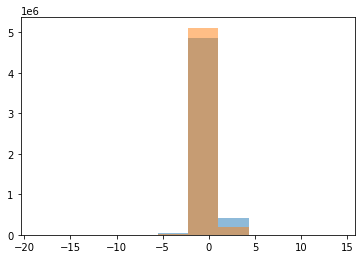

In [22]:
plt.hist(subtomo.squeeze().numpy().flatten(), alpha=0.5)
plt.hist(target.squeeze().numpy().flatten(), alpha=0.5)

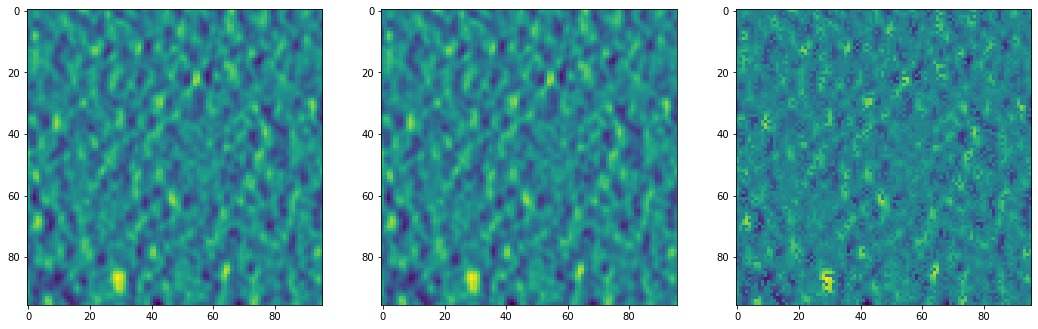

In [23]:
z0, y0, x0 = my_dataset.grid[idx]
zmin, zmax = z0-subtomo_length//2, z0+subtomo_length//2
ymin, ymax = y0-subtomo_length//2, y0+subtomo_length//2
xmin, xmax = x0-subtomo_length//2, x0+subtomo_length//2

aux_patch = tomo_data[zmin:zmax, ymin:ymax, xmin:xmax]

if gt_subtomo is not None:
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(18, 8))
    zidx = 43
    ax0.imshow((target+subtomo)[0][0][zidx])
    ax1.imshow(aux_patch[zidx])
    ax2.imshow(subtomo[0][0][zidx])
    ax3.imshow(gt_subtomo[0][0][zidx])
else:
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 8))
    zidx = 43
    ax0.imshow((target+subtomo)[0][0][zidx])
    ax1.imshow(aux_patch[zidx])
    ax2.imshow(subtomo[0][0][zidx])

In [24]:
(mask==0).sum()/torch.prod(torch.tensor(subtomo.shape))

tensor(0.3001)

In [25]:
((target + subtomo).squeeze() - aux_patch).abs().max()

tensor(0.)

(array([1.800000e+02, 2.220000e+02, 2.760000e+02, 5.220000e+02,
        5.605200e+04, 4.644678e+06, 6.045240e+05, 1.356000e+03,
        4.380000e+02, 1.680000e+02]),
 array([-18.754244 , -15.454923 , -12.155601 ,  -8.856279 ,  -5.5569577,
         -2.257636 ,   1.0416855,   4.341007 ,   7.6403284,  10.939651 ,
         14.238972 ], dtype=float32),
 <BarContainer object of 10 artists>)

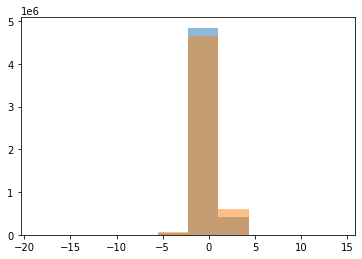

In [26]:
plt.hist(subtomo.squeeze().numpy().flatten(), alpha=0.5)
plt.hist((target+subtomo).squeeze().numpy().flatten(), alpha=0.5)

(array([3.8200000e+02, 1.7660000e+03, 3.3300000e+03, 4.5550000e+03,
        4.9020900e+05, 4.5295365e+07, 4.1434280e+06, 6.9820000e+03,
        2.2100000e+03, 4.4500000e+02]),
 array([-21.344042 , -17.567123 , -13.790206 , -10.0132885,  -6.2363706,
         -2.4594526,   1.3174652,   5.0943832,   8.871301 ,  12.648219 ,
         16.425137 ], dtype=float32),
 <BarContainer object of 10 artists>)

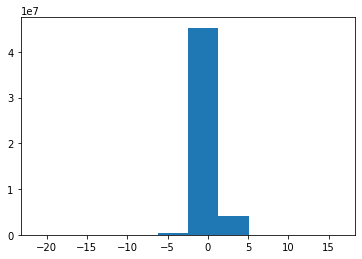

In [27]:
plt.hist(my_dataset.data.flatten().numpy())

# Fourier Dataset

In [2]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')
gt_cet_path = None
# simulated_model = 'model14'
# cet_path = os.path.join(
#     PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s_Poisson5000+Gauss5+stripes.mrc" %simulated_model
# )
# gt_cet_path = os.path.join(
#     PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s.mrc" %simulated_model
# )


p=0.3
batch_size = 8
num_gpus = 2
subtomo_length = 96
Vmask_probability = 0.5

deconv_kwargs = {'angpix': 14,
                 'defocus': 0,
                 'snrfalloff': 1,
                 'deconvstrength': 1,
                 'highpassnyquist': 0.3}

my_dataset = singleCET_FourierDataset(cet_path, subtomo_length, p=p, volumetric_scale_factor=8, gt_tomo_path=gt_cet_path,
                                      Vmask_probability=Vmask_probability)
print('Size of dataset: %i, Steps per epoch: %i' %(len(my_dataset), len(my_dataset)/(batch_size*num_gpus)))

Creating Fourier samples...
Done!
Size of dataset: 75, Steps per epoch: 4


In [3]:
my_dataset.dataF.shape, my_dataset.data.shape, my_dataset.fourier_samples.shape

(torch.Size([232, 464, 233]),
 torch.Size([232, 464, 464]),
 torch.Size([120, 1, 232, 464, 464]))

In [4]:
my_dataset.create_mask().shape

torch.Size([1, 232, 464, 233])

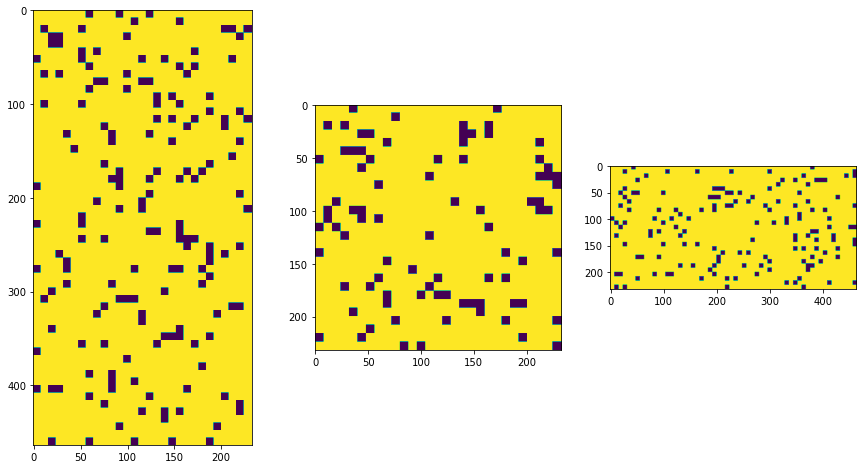

In [5]:
mask = my_dataset.create_Vmask()[0]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))

aux_idx = subtomo_length//2
ax0.imshow(mask[aux_idx])
ax1.imshow(mask[:,aux_idx, :])
ax2.imshow(mask[:, :,aux_idx])

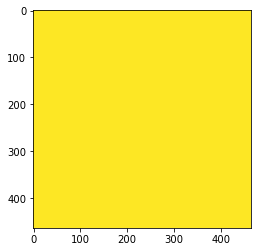

In [15]:
# grid sanity check: grid cover the entire tomogram
tomo_data = my_dataset.data

dummy_tomo = torch.zeros_like(torch.tensor(tomo_data))

for idx in range(len(my_dataset)):
    
    z0, y0, x0 = my_dataset.grid[idx]
    zmin, zmax = z0-subtomo_length//2, z0+subtomo_length//2
    ymin, ymax = y0-subtomo_length//2, y0+subtomo_length//2
    xmin, xmax = x0-subtomo_length//2, x0+subtomo_length//2

    dummy_tomo[zmin:zmax, ymin:ymax, xmin:xmax] = 1
    
plt.imshow(dummy_tomo[-1], vmin=0, vmax=1)

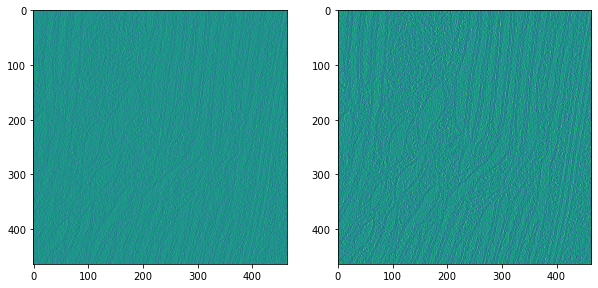

In [8]:
# Check how the original data and the ittf of the sampled fourier data are related
tomo_data = my_dataset.data

for s in range(len(my_dataset.fourier_samples)):
    
    dummy_tomo = torch.zeros_like(torch.tensor(tomo_data))
    for idx in range(len(my_dataset)):

        z0, y0, x0 = my_dataset.grid[idx]
        zmin, zmax = z0-subtomo_length//2, z0+subtomo_length//2
        ymin, ymax = y0-subtomo_length//2, y0+subtomo_length//2
        xmin, xmax = x0-subtomo_length//2, x0+subtomo_length//2

        dummy_tomo[zmin:zmax, ymin:ymax, xmin:xmax] = my_dataset.fourier_samples[s][0][zmin:zmax, ymin:ymax, xmin:xmax]

    zidx = dummy_tomo.shape[0]//2
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 8))
    ax0.imshow(dummy_tomo[zidx])
    ax1.imshow(my_dataset.data[zidx])
    plt.show()
    break

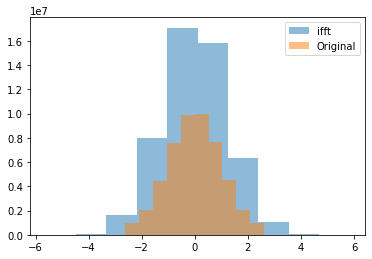

In [9]:
plt.hist(dummy_tomo.flatten().numpy(), alpha=0.5, label='ifft')
plt.hist(my_dataset.data.flatten().numpy(), alpha=0.5, label='Original')
plt.legend()

In [10]:
idx = len(my_dataset)//2
subtomo, target, gt_subtomo = my_dataset[idx]
subtomo.shape, subtomo.shape

(torch.Size([6, 1, 96, 96, 96]), torch.Size([6, 1, 96, 96, 96]))

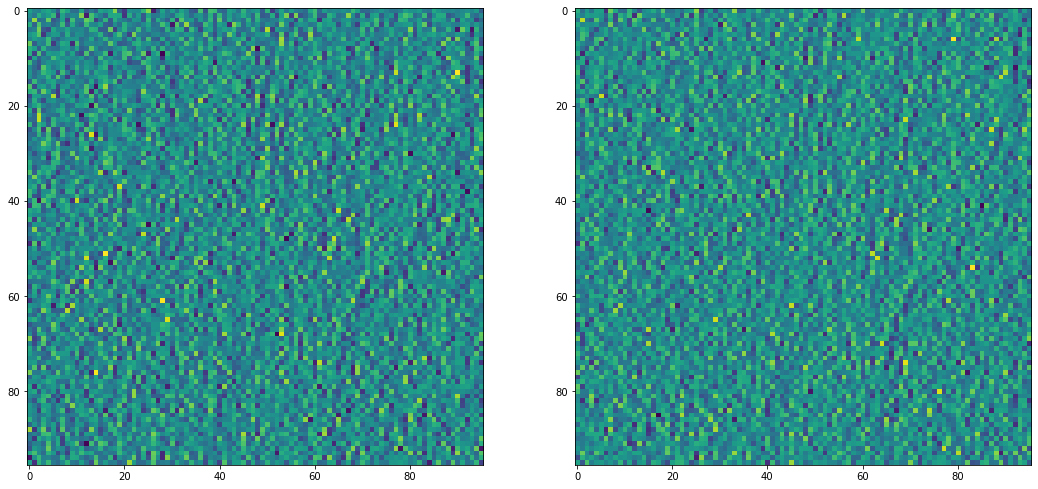

In [11]:
sample0 = subtomo[1][0]
sample1 = target[5][0]
zidx = sample0.shape[0]//2

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 10))
ax0.imshow(sample0[zidx])
ax1.imshow(sample1[zidx])

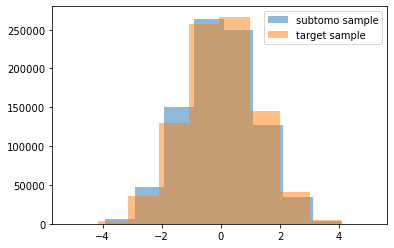

In [12]:
plt.hist(sample0.squeeze().numpy().flatten(), alpha=0.5, label='subtomo sample')
plt.hist(sample1.squeeze().numpy().flatten(), alpha=0.5, label='target sample')
plt.legend()

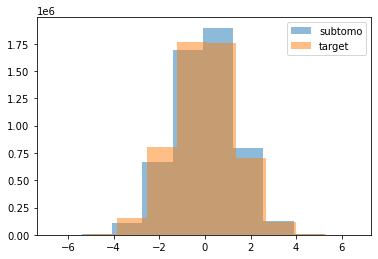

In [8]:
plt.hist(subtomo.squeeze().numpy().flatten(), alpha=0.5, label='subtomo')
plt.hist(target.squeeze().numpy().flatten(), alpha=0.5, label='target')
plt.legend()

(array([ 957361., 2013888., 4447247., 7560822., 9885007., 9926292.,
        7632401., 4506747., 2049110.,  969797.]),
 array([-2.618816 , -2.0960007, -1.5731853, -1.05037  , -0.5275547,
        -0.0047394,  0.5180759,  1.0408912,  1.5637065,  2.0865219,
         2.609337 ], dtype=float32),
 <BarContainer object of 10 artists>)

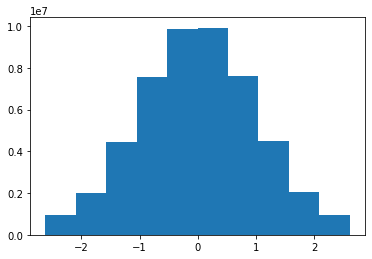

In [51]:
plt.hist(my_dataset.data.flatten().numpy())

# Projected Dataset

In [2]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')
gt_cet_path = None
# simulated_model = 'model14'
# cet_path = os.path.join(
#     PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s_Poisson5000+Gauss5+stripes.mrc" %simulated_model
# )
# gt_cet_path = os.path.join(
#     PARENT_PATH, "data/S2SDenoising/dummy_tomograms/tomoPhantom_%s.mrc" %simulated_model
# )


p=0.3
batch_size = 8
num_gpus = 2
subtomo_length = 64
Vmask_probability = 0.5

deconv_kwargs = {'angpix': 14,
                 'defocus': 0,
                 'snrfalloff': 1,
                 'deconvstrength': 1,
                 'highpassnyquist': 0.3}

my_dataset = singleCET_ProjectedDataset(cet_path, subtomo_length, gt_tomo_path=gt_cet_path, predict_simRecon=True, **deconv_kwargs)
print('Size of dataset: %i, Steps per epoch: %i' %(len(my_dataset), len(my_dataset)/(batch_size*num_gpus)))

Using simRecon0 and simRecon1 for training
Size of dataset: 256, Steps per epoch: 16


(array([2.2100000e+02, 1.8280000e+03, 6.8010000e+03, 1.0358400e+05,
        5.3006250e+06, 3.4082625e+07, 1.0192514e+07, 2.4864400e+05,
        1.0893000e+04, 9.3700000e+02]),
 array([-10.855818 ,  -8.921788 ,  -6.987758 ,  -5.053728 ,  -3.1196983,
         -1.1856685,   0.7483614,   2.6823912,   4.616421 ,   6.550451 ,
          8.484481 ], dtype=float32),
 <BarContainer object of 10 artists>)

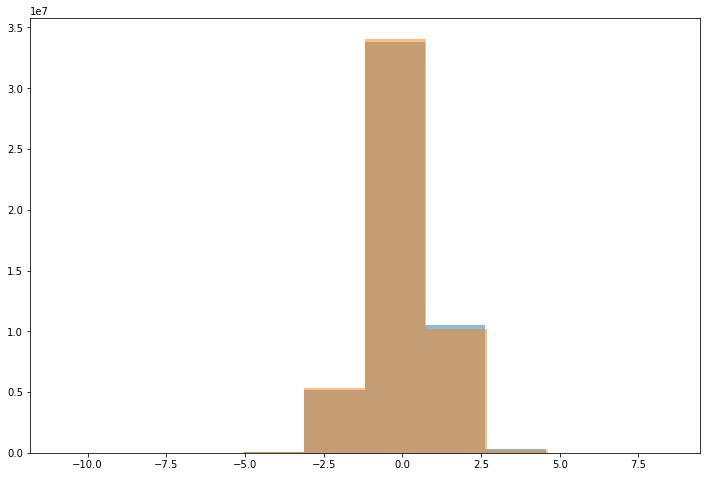

In [7]:
plt.figure(figsize=(12, 8))
plt.hist(my_dataset.simRecon0.numpy().flatten(), alpha=0.5)
plt.hist(my_dataset.simRecon1.numpy().flatten(), alpha=0.5)
# plt.hist(my_dataset.data.numpy().flatten(), alpha=0.5)

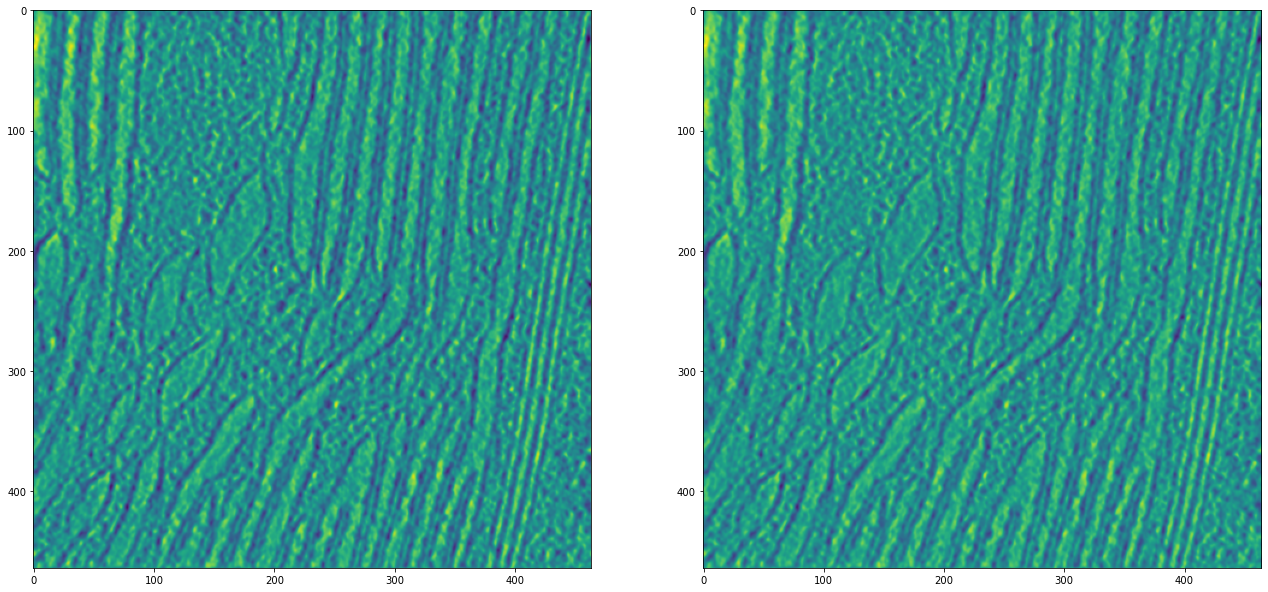

In [4]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 12))

ax0.imshow(my_dataset.simRecon0[my_dataset.tomo_shape[0]//2])
ax1.imshow(my_dataset.simRecon1[my_dataset.tomo_shape[0]//2])

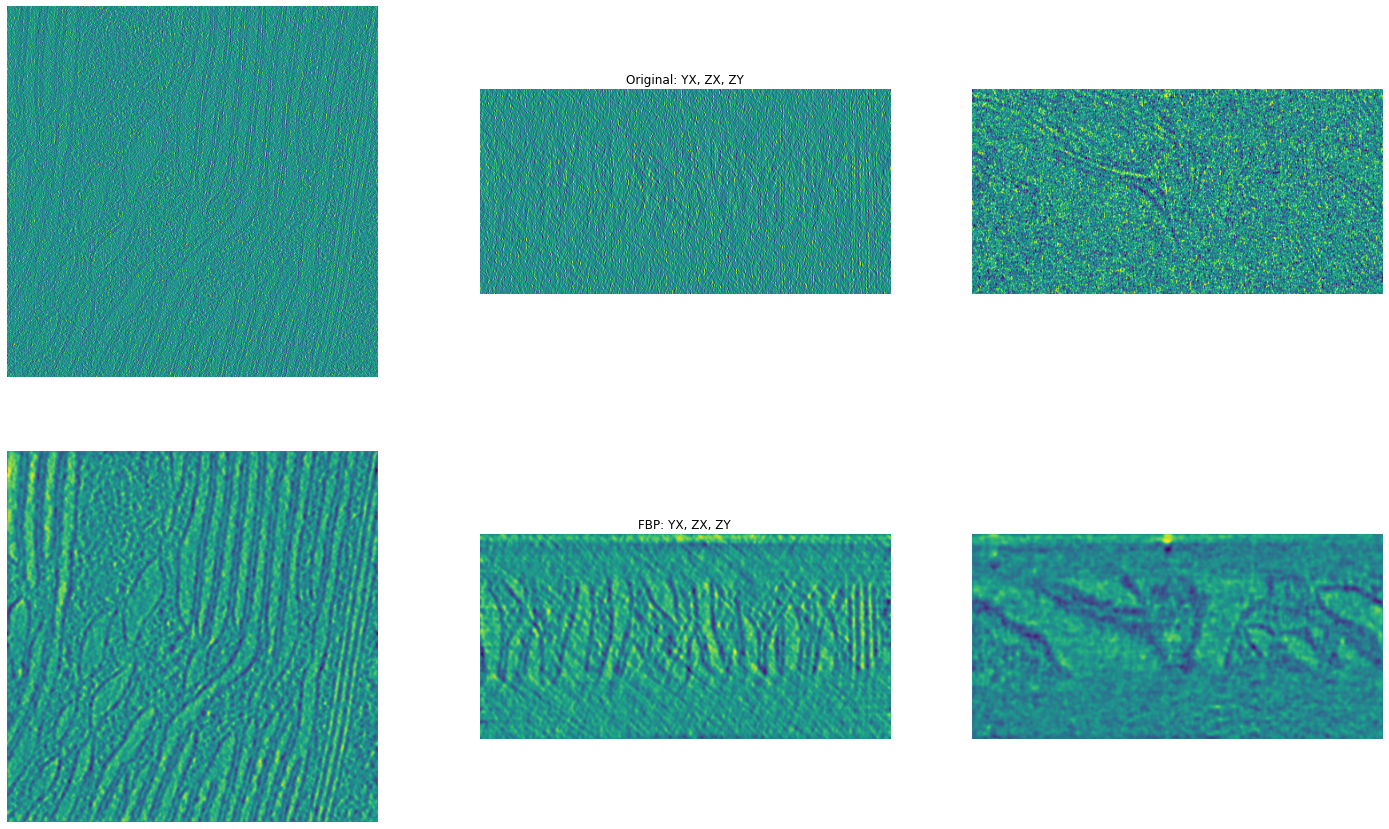

In [5]:
fig, (ax0, ax1) = plt.subplots(2, 3, figsize=(25, 15))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1]).ravel()))
zidx, yidx, xidx = np.array(my_dataset.tomo_shape)//2

ax0[1].set_title("Original: YX, ZX, ZY")
ax0[0].imshow(my_dataset.data[zidx])
ax0[1].imshow(my_dataset.data[:, yidx, :])
ax0[2].imshow(my_dataset.data[:, :, xidx])

ax1[1].set_title("FBP: YX, ZX, ZY")
ax1[0].imshow(my_dataset.simRecon0[zidx])
ax1[1].imshow(my_dataset.simRecon0[:, yidx, :])
ax1[2].imshow(my_dataset.simRecon0[:, :, xidx])

torch.Size([1, 64, 64, 64])


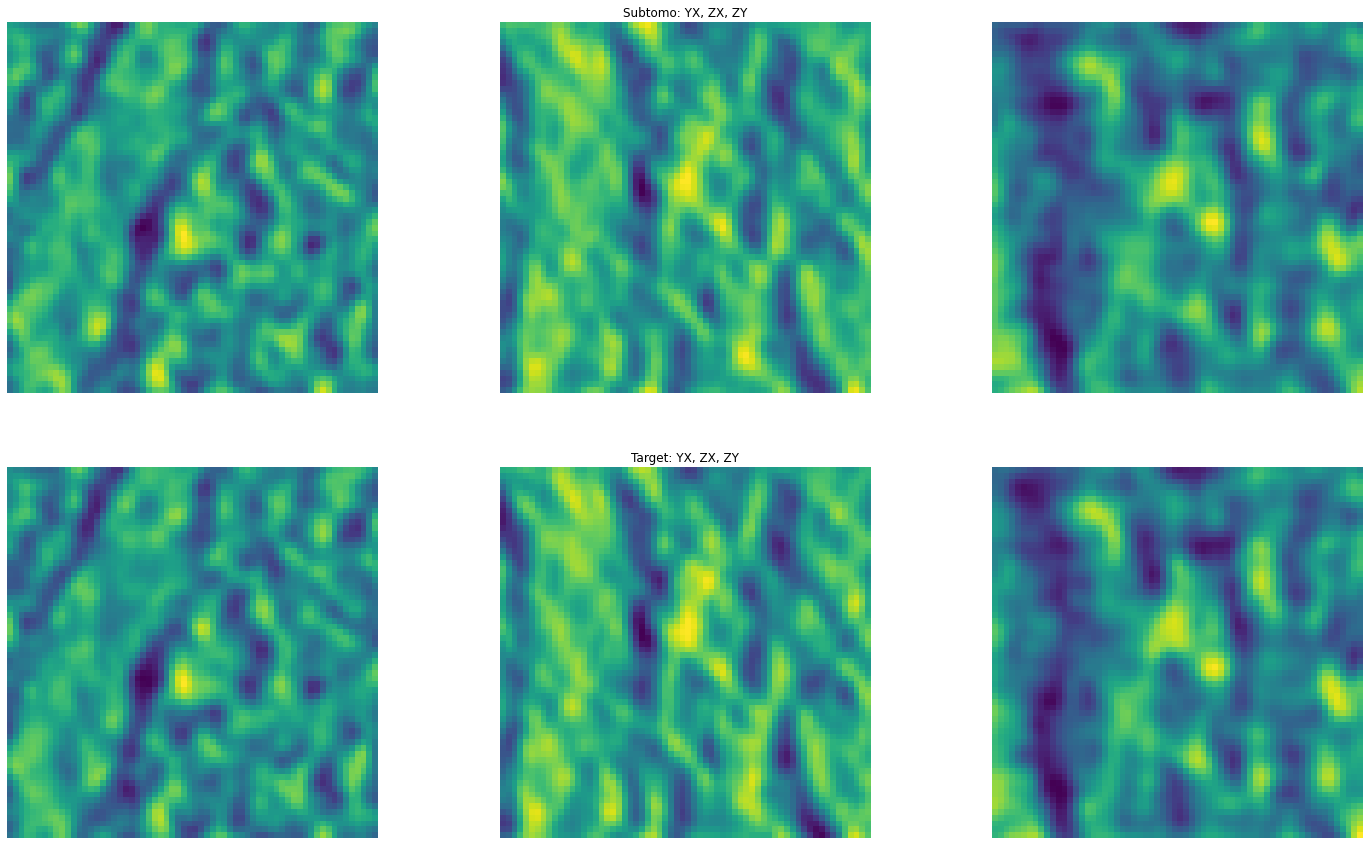

In [6]:
subtomo, target, gt_subtomo = my_dataset[100]
print(subtomo.shape)
subtomo, target = subtomo[0], target[0]

fig, (ax0, ax1) = plt.subplots(2, 3, figsize=(25, 15))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1]).ravel()))


ax0[1].set_title("Subtomo: YX, ZX, ZY")
ax0[0].imshow(subtomo[subtomo_length//2])
ax0[1].imshow(subtomo[:, subtomo_length//2, :])
ax0[2].imshow(subtomo[:, :, subtomo_length//2])

ax1[1].set_title("Target: YX, ZX, ZY")
ax1[0].imshow(target[subtomo_length//2])
ax1[1].imshow(target[:, subtomo_length//2, :])
ax1[2].imshow(target[:, :, subtomo_length//2])